## 1. Le problème avec la modélisation de longues séquences

Considérons le problème avec les architectures avant les LLMs qui n'avaient pas de mécanismes d'attention.
Par exemple, pour une tâche de traduction, on ne peut pas traduire un texte mot par mot  à cause des structures grammaticales du language source et cible.

Pour résoudre ce problème, il est commun d'utiliser une architecture de réseau de neurones avec deux sous modules : un encodeur pour lire et traiter le texte et un décodeur pour produire la traduction du texte.

Avant les transformers, les RNNs étaient l'architecture encodeur-décodeur la plus populaire pour la traduction.
* Un RNN est un type de réseau où les sorties des étapes précédentes sont fournis en entrée de l'étape en court, ce qui les rends adapté pour des données séquentielles comme le texte. Le texte en entrée est donné à l'encodeur qui va le traiter séquentiellement.
* L'encodeur met à jour son état caché (valeurs internes aux couches cachées) à chaque étape pour essayer de capturerle sens de la phrase en entrée dans son état caché final.
* Le décodeur prend ensuite l'état caché final pour commencer à générer la phrase traduite un mot à la fois. Il met aussi à jour son état caché à chaque étape, qui est supposé contenir le contexte nécessaire pour la prédiction du prochain mot.

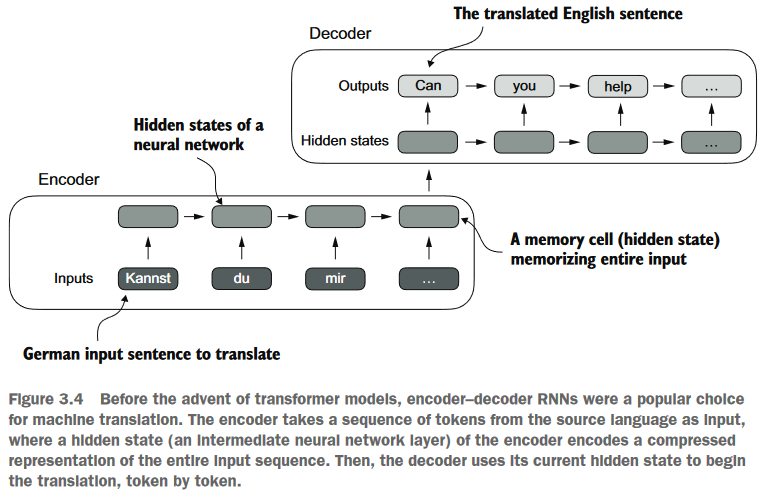

Une grosse limitation des RNNs encodeur-décodeur est que le RNN ne peut pas accéder directement aux états cachés passés de l'encodeur durant la phase de décodage. Ca dépend seulement sur l'état caché courant qui contient les informations pertinentes.
**Cela peut mener a une perte d'information du contexte, surtout dans les phrases complexes où les dépendances peuvent être éloignés.**

En conclusion, les RNNs fonctionnent bien pour traduire les phrases courtes, mais fonctionne moins bien pour les textes longs comme ils n'ont pas d'accès direct aux mots précédents de l'entrée. Un défaut majeur de cette approche est que le RNN doit se rappeler l'entrée encodée entière dans un seul état caché (une couche) avant de le passer au décodeur.

## 2. Capturer les dépendances avec des mécanismes d'attention

**La self-attention est un mécanisme qui permet à chaque position dans la séquence d'entrée à considérer la pertinance de toutes les autres positions dans la même séquence quand on calcul la représentation d'une séquence.**

Le 'self' dans self-attention fait référence à la capacité du mécanisme à calculer les poids d'attention en mettant en évidence les relations entre les positions dans une seule séquence en entrée. Ca apprend les relations et dépendances entre différentes parties de l'entrée elle-même comme des mots dans une phrase ou des pixels dans une image.

C'est en contraste avec les mécansimes d'attention tarditionelles où on s'intéresse aux relations entre les éléments de deux séquences différentes.

## 3. Un mécanisme d'attention simplifié  sans poids entrainable

Avec la sef-attention notre objectif est de calculer des vecteurs de contexte Z pour chaque éléments X de la séquence d'entrée.

Un vecteur de contexte peut être vu comme un vecteur d'embedding enrichi. Leur objectif est de créer une représentation enrichi de chaque élément dans une séquence d'entrée en encorporant des informations de tous les autres éléments de la séquence.



In [89]:
import torch
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

La première étape d'implémentation de la self-attention est de calculer des valeurs intermédiaires 'w' : les scores d'attention.

On détermine ses scores en calculant le produit scalaire de la query (x2) avec chaque autre token en entrée.

*Note : le produit scalaire (dot product) est une façon concise de multiplier deux vecteurs éléments par éléments et ensuite de sommer les produits. Le produit scalaire est une mesure de similarité car ça quantifie à quel point deux vecteurs sont alignés. Une valeur plus haute indique  un meilleur degré d'alignement  ou de similarité entre les vecteurs.*

In [90]:
# Exemple avec la seconde entrée x2 qui sert comme query
query = inputs[1]

# Calcul du produit scalaire
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
  attn_scores_2[i] = torch.dot(x_i, query)
print("Attention scores:", attn_scores_2)

Attention scores: tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


On normalise ensuite les scores d'attention pour obtenir des poids d'attention dont la somme sera égale à 1. C'est aussi une convention qui est utile pour l'interprétabilité et maitenir une stabilité durant l'entrainement du LLM.

Utiliser la fonction softmax pour la normalisation est meilleure pour gérer les valeurs extrèmes et offre des propriétés plus favorable du gradient durant l'entrainement.
En plus la fonction softmax s'assure que les poids d'attention soient toujours positifs.



In [91]:
# Normalisation des scores (interprétabilité et stabilité de l'entrainement)
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

# Normalisation avec softmax (meilleur pour les valeurs extremes)
def softmax_naive(x):
  return torch.exp(x) / torch.exp(x).sum(dim=0)
attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

# Normalisation avec softmax de torch (optimisé pour les perfs)
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


On calcule ensuite les vecteurs de contexte Z en multipliant les embedings des tokens en entrée X avec les poids d'attention correspondant et en sommant les vecteurs résultants.

Ainsile vecteur de contexte Z est la somme pondéré de tous les vecteurs en entrée, obtenu en multipliant chaque vecteur d'entrée par son poid d'attention correpondant.

In [92]:
# Calcul du vecteur de contexte z2
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
  context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


Maitenant on généralise cette procédure pour calculer tous les vecteurs de contexte en même temps.

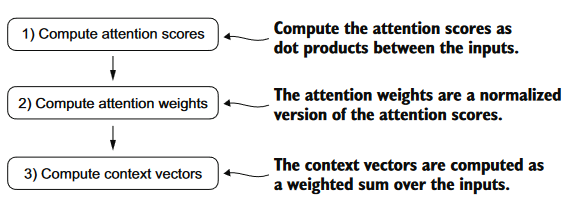

In [93]:
# Calcul de tous les scores d'attention avec une boucle for
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
  for j, x_j in enumerate(inputs):
    attn_scores[i, j] = torch.dot(x_i, x_j)

# Calcul des scores d'attention avec une multiplication matricielle (plus rapide)
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [94]:
# Calcul des poids d'attention en normalisant chaque ligne
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)
print("All row sums:", attn_weights.sum(dim=-1))

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [95]:
# Calcul des vecteurs de context avec une multiplication matricielle
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## 4. Self-attention avec des poids entrainables

On va ajouter des poids entrainables au mécansime de self-attention pour permettre au LLM d'apprendre des données et améliorer ses performances sur des taches spécifiques.

*Note : le mécanisme de self-attention utilisé dans le transformer originel, les modèles GPT ou les LLMs les plus populaires est **aussi appelé 'scaled dot-product attention'**.*

Il n'y a que quelques différences par rapport au mécanisme d'attention basique codé avant. **La différence la plus importante est l'introduction de matrices de poids qui sont mises à jour durant l'entrainement du modèle. Ces matrices de poids permettent au modèle d'apprendre à produire de bons vecteurs de contexte.**

### 4.1 Calcul des poids d'attention étape par étape



On introduit les 3 matrices de poids entrainables Wq, Wk et Wv. Ces trois matrices sont utilisées pour projeter les représentations des tokens d'entrée en vecteurs 'query', 'key' et 'value'

In [96]:
x_2 = inputs[1]               # 2ème élément de l'entrée
d_in = inputs.shape[1]        # taille des embeddings en entrée
d_out = 2                     # taille des embeddings en sortie
print(x_2)

tensor([0.5500, 0.8700, 0.6600])


In [97]:
# Initialisation des matrices de poids
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [98]:
# Calcul des vecteurs query, key et value
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


Même si on veut calculer seulement le vecteur de context Z2, on a besoin des vecteurs key et value pour tous les éléments de l'entrée pour calculer les poids d'attention par rapport à la querry q2.

In [99]:
# Calcul de toutes les key et value via multiplication matricielle
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [100]:
# Calcul du score d'attention W22
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

# Calcul de tous les scores d'attention pour une querry via multiplication matricielle
attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor(1.8524)
tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


Pour passer des scores d'attention aux poids d'attention, on met à l'échelle les scores d'attention et on utilise la fonction softmax.

**Pour mettre à l'échelle les scores d'attention, on les divise par la racine carré de la dimenssion des embeddings des keys.**
* Cela permet d'améliorer les performances de l'entrainement en évitant les petits gradients. Des gradients proches de 0 peuvent ralentir l'entrainementou  faire que l'entrainement stagne.
* La mise à l'échelle par la racine carré de la dimenssion de l'embedding est la raison pour la laquelle ce mécanisme de self-attentionest aussi appelé 'scaled-dot product attention'

In [101]:
# Calcul des poids d'attention pour une querry
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


On calcule vecteur de contexte comme une somme pondérépar rapports aux vecteurs value. Les poids d'attention servent comme un facteur pondéré qui pondére l'importance respective de chaque vecteur value.

In [102]:
# Calcul du vecteur contexte
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


On a seulement calculéun seul vecteur de contexte Z2. Nous allons généraliser le code pour calculer tous les vecteurs contextes.

### 4.2 Class Python compacte pour la self-attention

On va utiliser nn.Linear pour les matrices de poids Wq, Wk et Wv plutot que nn.Parameter(torch.rand(...)) car nn.Linear a un schéma d'initlisation des poids optimisé, ce qui va contribuer à un entrainement de modèle plus stable et efficace.

In [103]:
import torch.nn as nn

class SelfAttention(nn.Module):
  def __init__(self, d_in, d_out, qkv_bias=False):
    """Initialisation des matrices de poids entrainables, chacunes transformant
    la dimenssion d'entrée d_in en la dimenssion d_out."""
    super().__init__()
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

  def forward(self, x):
    """Calcul des scores d'attention, des poids d'attention puis des vecteurs contextes."""
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)
    attn_scores = queries @ keys.T # omega
    attn_weights = torch.softmax(
      attn_scores / keys.shape[-1]**0.5, dim=-1
    )
    context_vec = attn_weights @ values
    return context_vec

In [104]:
torch.manual_seed(123)
self_attention = SelfAttention(d_in, d_out)
print(self_attention(inputs))

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)


Comme l'entrée contient 6 vecteurs d'embedding, on obtient une matrice avec 6 vecteurs de contexte.

## 5. Causal attention ou masked attention

### 5.1 Application d'un masque pour la causal attention étape par étape

Pour de nombreuses tâches de LLM, on veut que le mécanisme de self-attentionconsidère seulement les tokens qui apparaissent avant la position actuelle quand on veut prédire le prochain token d'une séquence.

**La causal attention, ou masked attention, est une forme spécialisé de self-attention ou le modèle peux considérer seulement les entrées précédentes et courante d'une séquence quand il traite un token lors du calcul des scores d'attention.**

Pour faire cela, pour chaque token traité on masque les futurs tokens. On masque les poids d'attention sur la diagonale et on normalise les poids d'attention non masqué pour que la somme des poids d'attention sur une ligne soit égale à 1.

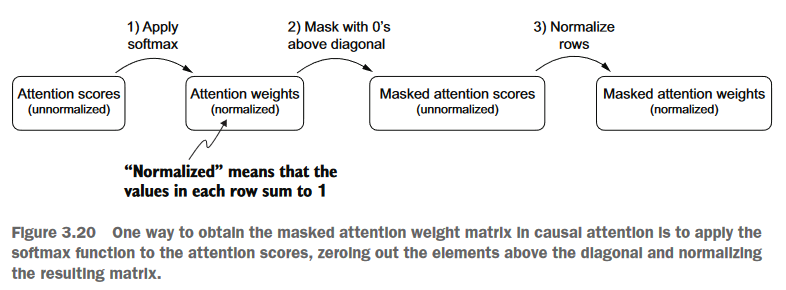

In [105]:
#  0 - Calcul des scores d'attention comme avant
queries = self_attention.W_query(inputs)
keys = self_attention.W_key(inputs)  # On réutilise les matrices de poids pour la simplicité
attn_scores = queries @ keys.T

In [106]:
# 1 - Calcul des poids d'attention avec softmax
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1717, 0.1762, 0.1761, 0.1555, 0.1627, 0.1579],
        [0.1636, 0.1749, 0.1746, 0.1612, 0.1605, 0.1652],
        [0.1637, 0.1749, 0.1746, 0.1611, 0.1606, 0.1651],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.1632, 0.1674],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.1639],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


In [107]:
# 2 - Création d'un masque avec des 0 au dessus de la diagonale
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))

# Application du masque
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1749, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1637, 0.1749, 0.1746, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.0000, 0.0000],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<MulBackward0>)


In [108]:
# 3 - On renormalise les poids d'attention pour que la somme égale 1 sur les lignes
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<DivBackward0>)


**On peut améliorer l'efficacité de notre implémentation en utilisant une propriété mathématique de la fonction softmax.**

La fonction softmax convertis ses entrées en une distribution de probabilité. Quand ses valeurs -infini sont présent dans une ligne, la fonction softmax les traite comme des 0

Pour implémenter ça efficacement, on va créer un masque avec des 1 au dessus de la diagonale puis on va remplacer ces 1 avec des valeurs -infini.

In [109]:
# 1 - Création du masque et application sur les scores d'attention
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.3111,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1655, 0.2602,   -inf,   -inf,   -inf,   -inf],
        [0.1667, 0.2602, 0.2577,   -inf,   -inf,   -inf],
        [0.0510, 0.1080, 0.1064, 0.0643,   -inf,   -inf],
        [0.1415, 0.1875, 0.1863, 0.0987, 0.1121,   -inf],
        [0.0476, 0.1192, 0.1171, 0.0731, 0.0477, 0.0966]],
       grad_fn=<MaskedFillBackward0>)


In [110]:
# 2 - Application du softmax sur ces résultats masqués
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


### 5.2 Masquer des poids d'attention additionels avec du dropout

**Le Dropout est une technique ou des unités de couches cachées choisis aléatoirement sont ignorés durant l'entrainement. Cela permet de réduire le risque d'overfitting en s'assurant que le modèle ne devienne pas trop confiant sur un set spécifique d'unité de couche cachée.**
Le dropout est seulement utilisé durant l'entrainement et désactivé après.

Dans les architectures transfromers, comme GPT, le dropout est appliqué dans les mécanismes d'attention est appliqué à deux moments spécifiques : après avoir calculé les poids d'attention ou  après avoir appliqué les poids d'attention aux vecteurs value.
**Le plus commun est d'appliquer le masque dropout après avoir calculé les poids d'attention.**

In [111]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


En appliquant le dropout avec un taux de 50%, la moitié des éléments de la matrices sont mis à 0 aléatoirement. **Pour compenser la réduction d'éléments actifs, les valeurs des éléments restants de la matrice sont multipliés par un facteur 1/0.5=2.** C'est crucial pour maintenir l'équilibre global des poids d'attention, **pour s'assurer que l'influence moyenne des mécanismes d'attention reste constante durant l'entrainement et l'inférence.**

### 5.3 Classe Python compacte pour la causal attention

In [112]:
# On créé un bactch pour s'assurer que le code puisse le gérer
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [113]:
import torch.nn as nn

class CausalAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
    """Initialisation des matrices de poids entrainables, chacunes transformant
    la dimenssion d'entrée d_in en la dimenssion d_out."""
    super().__init__()
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
      'mask',
      torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    """Calcul des scores d'attention, des poids d'attention puis des vecteurs contextes."""
    b, num_tokens, d_in = x.shape

    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # On transpose les dim pour garder la dim du batch en 1ère position
    attn_scores = queries @ keys.transpose(1, 2)
    attn_scores.masked_fill_(  # En torch les opération avec un _  sont faites sur place en évitant des copies de mémoires non nécessaires
      self.mask.bool()[:num_tokens, :num_tokens],
      -torch.inf
    )

    attn_weights = torch.softmax(
      attn_scores / keys.shape[-1]**0.5, dim=-1
    )
    attn_weights = self.dropout(attn_weights)

    context_vec = attn_weights @ values
    return context_vec

*Note : l'utilisation de **register_buffer** en PyTorch offre des avantages. Par exemple, les buffers sont automatiquement déplacé sur le device approprié (CPU ou GPU) avec le modèle. Ce qui veut dire qu'on ne devra pas s'assurer manuellment que ces tensors soient sur le même device que les paramètres du modèle, ce qui évite des erreurs de 'device mismatch'*

*Note : En torch les opération avec un _ à la fin (ex: masked_fill_) sont faites sur place en évitant des copies de mémoires non nécessaires.*

In [114]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


## 6. Etendre la single-head attention à la multi-head attention

Le terme 'multi-head' fait référence au fait de diviser le mécansime d'attention en plusieurs 'heads', chaque opérante de façon indépendante.

Dans ce contexte, un seul module de causal attention peut être considéré comme de la single-head attention, où il n'y a qu'un set de poids d'attention qui va traiter la séquence token après token.

### 6.1 Empiler plusieurs couches de single-head attention

**En terme pratique, implémenter la multi-head attention implique de créer plusieurs instances de mécanisme de self-attention, chacunes avec ses propres poids, et de combiner leurs sorties.**

Le principe de la multi-head attention est d'exécuter (en parallèle) le mécansime d'attention plusieurs fois avec différentes projections linéaires apprises.



In [115]:
# Classe surcouche pour implémenter la multihead attention
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    self.heads = nn.ModuleList([
        CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
      for _ in range(num_heads)]
    )
  def forward(self, x):
    # Concaténation des num_heads matrices de vecteur contexte
    return torch.cat([head(x) for head in self.heads], dim=-1)

In [116]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2

mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


La première dimenssion du tensor context_vecs est 2 car on a deux textes en entrée, la seconde dimenssion est pour les 6 tokens de cahque entrée et la troisième entrée est pour l'embedding de dimenssion 4 pour chaque token.

On a implémenter un wrapper qui combine plusieurs modules de single-head attention. Cependant, elles sont appliqués de façon séquentielle.
On peut améliorer cette implémentation en traitant les heads en parallèle.

### 6.2 Implémentation de l'attention multi-head avec des poids séparés

La séparation des tensors quey, key et value est effectué avec une opération de reformation (.view) et de transposition (.transpose).

L'entrée est d'abord transformé, via des couches linéaires pour les queries, keys et values, et ensuite reformé pour représenter plusieurs heads.
L'opération clé est de s"parer la dimenssion d_out en num_heads et head_dim. Cette séparation est effectué avec la méthode view().

In [117]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    """Initialisation de la classe pour calculer la multi-head attention."""
    super().__init__()
    assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    # Réduit la dim de projection pour correspondre à la dim de sortie souhaité
    self.head_dim = d_out // num_heads
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    # Utilise une couche linéaire pour combiner les sorties des heads
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
      "mask",
      torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    """Calcul de la multi-head attention."""
    b, num_tokens, d_in = x.shape

    # 1. Calcul des keys, querries, values
    keys = self.W_key(x)  # (batch, num_tokens, d_out)
    queries = self.W_query(x)
    values = self.W_value(x)

    # 2. Division des matrices en plusieurs heads
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)  # (batch, num_tokens, num_heads, head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
    keys = keys.transpose(1, 2)  # (batch, num_heads, num_tokens, head_dim)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    # 3. Calcul du score d'attention
    attn_scores = queries @ keys.transpose(2, 3)  # produit scalaire pour chaque tête

    # 4. Application du masque pour la causalité
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # Masque tronqué au nombre de tokens
    attn_scores.masked_fill_(mask_bool, -torch.inf)  #     # Utilise le masque sur les scores d'attention

    # 5. Calcul des poids d'attention
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    # 6. Calcul des vecteurs de context
    context_vec = (attn_weights @ values).transpose(1, 2)  # (batch, num_tokens, num_heads, head_dim)
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)  # Combinaison des heads avec d_out=num_heads*head_dim
    context_vec = self.out_proj(context_vec)  # Ajoute une proj linéaire optionelle
    return context_vec

Même si la classe MultiHeadAttention semble plus compliqué MultiHeadAttentionWrapper à cause des reqhaping et transposition supplémentaire de tensors, c'est plus efficace.
On a besoin d'une seule multiplication matricielle pour calculer les keys (même chose pour les queries et values).

In [121]:
# Exemple de multiplication matricielle à 4 dimenssions

# a (batch, num_heads, num_tokens, head_dim)=(1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],
                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

# Multiplication matricielle pour chacune des 2 heads séparemment
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)
second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

# Multiplication matricielle groupé (batched) = plus compact
print("\nBatched:\n", a @ a.transpose(2, 3))

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])

Batched:
 tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


In [123]:
# Utilisation de la MultiHeadAttention
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


En comparaison, le plus petit modèle de la famille GPT-2 avec 117 millions de paramètres a 12 attention heads et une taille d'embedding pour les vecteurs de contexte de 768. Le plus gros GPT-2 avec 1.5 milliard de paramètres a 25 attention heads et une taille d'embedding pour le vecteur de contexte de 1600.

Dans les modèles GPT, les tailles des embeddings des tokens en entrée et des embedding de contexte sont les mêmes (d_in=d_out).

In [124]:
# Initialisation d'un module d'attention de la même taille que ceux de GPT-2
mha = MultiHeadAttention(
    d_in=768,
    d_out=768,
    context_length=1024,
    dropout=0.2,
    num_heads=12
)

## A retenir

* Les mécanismes d'attention transforment les éléments en entrée en représentations vectorielles de contexte améliorées en intégrant des informations sur toutes les entrées.
* Un mécanisme de self-attention calcul la représentation vectorielle de contexte comme une somme pondérée sur les entrées.
* Dans un mécanisme d'attention simplifié, les poids d'attention sont calculés avec des produits scalaires.
* Un produit scalaire est façon concise de multiplier deux vecteurs éléments par éléments puis de sommer les produits.
* Les multiplications matricielles, tout en étant pas strictement requise, nous aide à implémenter des calculs plus efficacement et plus compacte en remplaçant des boucle for.
* Dans les mécanismes de self-attention utilisés dans les LLMs, aussi appelé 'scaled-dot product attention', on inclut des matrices de poids entrainables pour calculer des transformations intéermdiaires des entrées : les queries, keys et values.
* En travaillant avec des LLMs qui lisent et générent du texte de gauche à droite, on ajoute un masque de causal attention pour empêcher le LLM d'accéder aux futurs tokens.
* En plus des masques de causal attention pour mettre à zéro les poids d'attention, on peut ajouter un masque de dropout pour réduire l'overfitting dans les LLMs.
* Les modules d'attention dans les LLMs à base de transformer impliquent plusieurs instances de causal attention, ce qui est appelé multi-head attention.
* On peut créer un module de multi-head attention en empilant plusieurs instances de modules de causal attention.
* Une façon plus efficace de création des modules de multi-head attention implique des multiplication matricielles batchées.